# Explaining Acquisition Functions
"Acquisition functions" are the tools used to assign value to individual experiments. 
We demonstrate [a few of the commons ones](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Acquisition-functions.html) in this notebook.

Learning objectives:
- [ ] How to train and produce uncertainty estimates from a Gaussian Process Regression model
- [ ] Understanding how the mean and uncertainty of a prediction are used in acquisition functions

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## Generate Target Function and Model
Let's use a made up test function. Imagine that this is the internal physics of some process, but we don't actually know the form. The only way to get more information is to "run experiments," i.e. sample values of the function.

### Defining a Target Function and Training Set
Before we get started with training a model, let's define the problem. We choose a function with two maxima to illustrate a global optimization problem and intentionally select points that sample only areas near the lesser of the two maxima to illustrate the advantages of explorative experimental design.

In [2]:
def func(X):
    return -1*np.cos(X) + 0.05*X

In [3]:
X = np.linspace(-5, 5, 1000)
y = func(X)

In [4]:
X = np.expand_dims(X, 1)  # Makes X into a 2D array, as expected by sklearn

Pick a few points and train an initial model

In [5]:
X_train = np.expand_dims([-4.5, -3.5, -2.5, -1.5, -0.5, 2, 5], 1)
y_train = np.squeeze(func(X_train))

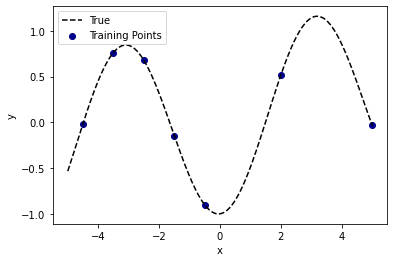

In [6]:
fig, ax = plt.subplots()

ax.plot(X, y, 'k--', label='True')

ax.scatter(X_train, y_train, label='Training Points', color='darkblue')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

See how we have the first local maximum nearly located with our training points, but do not have many points near the global maximum. 

### Setting up a GPR Model
We are going to use a Gaussian Process Regression (GPR) model for this example. GPR is a machine learning technique that relies on a "kernel function" that computes the similarity between a new point and the training examples as the basis for making predictions. We will first illustrate the choice for that kernel then show how to train and use the model.

A prediction from a GPR model is defined by a sum over kernel function (read as: similarity function) between a point and selected points from the training set:

$f(x) = \sum_i \alpha_i k(x, x_i)$

We chose a [Matern](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern) kernel to express the similarity between two data points ($k(x, y)$). The Matern kernel expressess similarity based on the Euclidean distance between two points, where points with smaller distances are more similar. It has a smoothness parameter, $\nu$, that controls how quickly similarity drops off with distance and a length-scale that controls the characteristic length of the distances. 

In [7]:
kernel = Matern()
kernel

Matern(length_scale=1, nu=1.5)

Text(0, 0.5, 'k(0, x)')

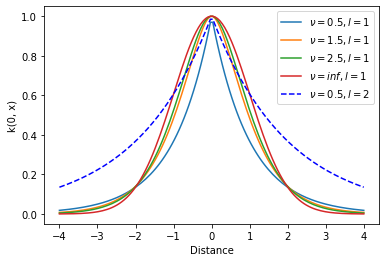

In [8]:
fig, ax = plt.subplots()

x0 = np.zeros((1, 1))
x1 = np.linspace(-4, 4, 128)[:, None]

kernel.length_scale = 1
for n in [0.5, 1.5, 2.5, np.inf]:
    kernel.nu = n
    ax.plot(x1.ravel(), kernel(x0, x1).ravel(), label=f'$\\nu = {n:.1f}, l = 1$')

kernel.length_scale = 2
kernel.nu = 0.5
ax.plot(x1.ravel(), kernel(x0, x1).ravel(), 'b--', label=f'$\\nu = 0.5, l = 2$')
    
ax.legend()

ax.set_xlabel('Distance')
ax.set_ylabel('k(0, x)')

Note how the sharpness of the center changes with $\nu$ and the width of the function changes with width. We choose a moderate sharpness of $\nu=1.5$. As we will demonstrate, the length scale is learned from the data.

We start to fit the model by defining a [`GaussianProcessRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor) object that will learn that length scale parameter and the coefficients of a model ($\alpha$).

In [9]:
kernel = Matern()  # Reset to default values
model = GaussianProcessRegressor(kernel=kernel)

We fit it just as any other scikit-learn model

In [10]:
model.fit(X_train, y_train)
print('fit hyperparameters:', model.kernel_)

fit hyperparameters: Matern(length_scale=1.95, nu=1.5)


Note how we selected an optimal value for the length scale.

In [11]:
print('Training points:', model.X_train_.ravel())

Training points: [-4.5 -3.5 -2.5 -1.5 -0.5  2.   5. ]


In [12]:
print('Coefficients (alpha):', model.alpha_)

Coefficients (alpha): [-1.54586317  1.81720652  0.5846188   0.39378672 -2.13582125  1.15219709
 -0.25146139]


We can see that the model is a summation of basis functions based on the Mattern kernel

In [13]:
# Compute the contribution to the total model from each function
contrib = model.alpha_ * model.kernel_(X, model.X_train_)

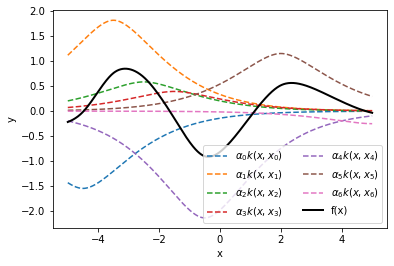

In [14]:
fig, ax = plt.subplots()

for i, contrib_i in enumerate(contrib.T):
    ax.plot(X, contrib_i, '--', label=f'$\\alpha_{i} k(x, x_{i})$')
ax.plot(X, contrib.sum(axis=1), 'k-', lw=2, label='f(x)')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=2)

Note how the model is a summation over these basis function.

There is [some math](https://bookdown.org/rbg/surrogates/chap5.html#chap5gppost) that permits us to also compute the uncertainity of the model prediction at each point.

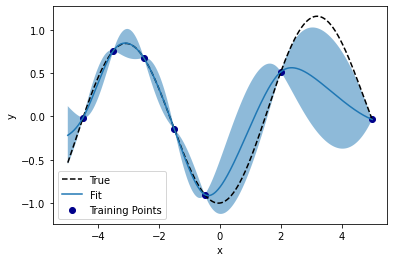

In [15]:
fig, ax = plt.subplots()

ax.plot(X, y, 'k--', label='True')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X), label='Fit')
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, label='Training Points', color='darkblue')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

Note how the uncertainity is 0 at points we have sampled already and grows in the region between points.

## Explore Acquisition Functions
Acquisition functions define the value of sampling a certain point on [achieving an experimental objective](https://distill.pub/2020/bayesian-optimization/). 
These objectives could be to minimize the total uncertainty over a space or to find an optimal value of a function.
In this section, we demonstrate different aquistion functions to illustrate the different ways we can choose to explore this space.

### Random Sampling
Assigning a random value to each point is a perfectly valid acquistion function. 
We can write the function out as: $a_{random}(x) = U(0, 1)$
where $a(x)$ is the value for point $x$ and $U$ is the uniform distribution.

In [16]:
value = np.random.uniform(low=-5, high=5, size=len(X))

In [17]:
chosen_point = np.argmax(value)

Text(0.5, 0, 'x')

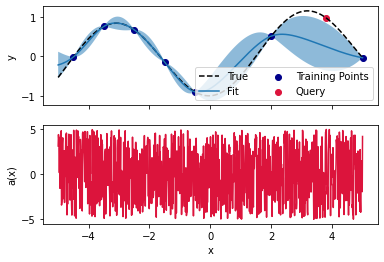

In [18]:
fig, axs = plt.subplots(2, 1, sharex=True)

# Plot the true function
ax = axs[0]
ax.plot(X, y, 'k--', label='True')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X), label='Fit')
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, label='Training Points', color='darkblue')
ax.scatter([X[chosen_point]], y[chosen_point], label='Query', color='crimson')

ax.set_ylabel('y')
ax.legend(ncol=2)

ax = axs[1]

ax.plot(X, value, color='crimson')
ax.set_ylabel('a(x)')
ax.set_xlabel('x')


There is no logic to how this point is chosen

### Greedy Sampling
Another simple strategy is to value a point based only on the mean prediction: $a_{greedy} = \mu(x)$
where $\mu$ is the mean of model's predictions at point

In [19]:
value = model.predict(X)

In [20]:
chosen_point = np.argmax(value)

Text(0.5, 0, 'x')

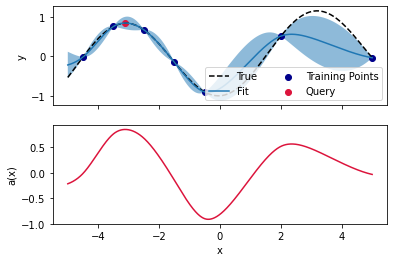

In [21]:
fig, axs = plt.subplots(2, 1, sharex=True)

# Plot the true function
ax = axs[0]
ax.plot(X, y, 'k--', label='True')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X), label='Fit')
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, label='Training Points', color='darkblue')
ax.scatter([X[chosen_point]], y[chosen_point], label='Query', color='crimson')

ax.set_ylabel('y')
ax.legend(ncol=2)

ax = axs[1]

ax.plot(X, value, color='crimson')
ax.set_ylabel('a(x)')
ax.set_xlabel('x')

Given the choice of a model form that is a summation over radial-basis functions (i.e., [Matérn functions](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function)), the chosen point is likely to be very close to the maximum value from the training points.

### Probability of Improvement
Another common acquisition function is to compute the likelihood that a point will be above a certain threshold.
Customariliy, the threshold is the often the maximum of the training points (i.e., $f' = \max f$).
If we assume the probability distribution of values for a certain points are modeled by normal distribution, the 
probability of improvement can be exprssed as:

$a_{PI}(x) = 1 - \Phi(f', \mu(x), \sigma(x))$

where $\Phi$ is the cumulative distribution function for the normal distribution and $\sigma$ is the predicted standard deviation of for point $x$.
See [Roman Garnett's lecture notes](https://www.cse.wustl.edu/~garnett/cse515t/spring_2015/files/lecture_notes/12.pdf) for a derivation.

In [22]:
y_pred, y_std = model.predict(X, return_std=True)
f_max = np.max(y_train)
value = [1 - stats.norm(u, s).cdf(f_max) for u, s in zip(y_pred, y_std)]

In [23]:
chosen_point = np.argmax(value)

Text(0.5, 0, 'x')

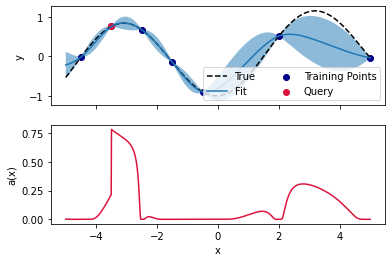

In [24]:
fig, axs = plt.subplots(2, 1, sharex=True)

# Plot the true function
ax = axs[0]
ax.plot(X, y, 'k--', label='True')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X), label='Fit')
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, label='Training Points', color='darkblue')
ax.scatter([X[chosen_point]], y[chosen_point], label='Query', color='crimson')

ax.set_ylabel('y')
ax.legend(ncol=2)

ax = axs[1]

ax.plot(X, value, color='crimson')
ax.set_ylabel('a(x)')
ax.set_xlabel('x')

Note that the $a$ value for the best point from the training set will be 0.5 because $\mu = f'$ for this point, meaning that 50% of the distribution lies above the chosen point.

### Upper Confidence Bounds (UCB)
The "upper confidence bound" (UCB) expresses the value for a point as a tradeoff between exploitation and exploration:

$a_{UCB}(x) = \mu(x) + \beta\sigma(x)$

where $\beta$ is a tradeoff parameter. Larger values of $\beta$ will lead to greater weight to uncertainty ($\sigma$) and, thereby, more exploration

In [25]:
y_pred, y_std = model.predict(X, return_std=True)
value_1 = y_pred + y_std
value_2 = y_pred + 2 * y_std

In [26]:
chosen_point_1 = np.argmax(value_1)
chosen_point_2 = np.argmax(value_2)

Text(0.5, 0, 'x')

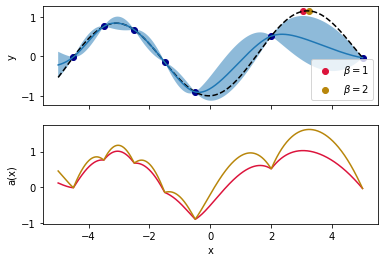

In [27]:
fig, axs = plt.subplots(2, 1, sharex=True)

# Plot the true function
ax = axs[0]
ax.plot(X, y, 'k--')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X))
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, color='darkblue')
ax.scatter([X[chosen_point_1]], y[chosen_point_1], label='$\\beta=1$', color='crimson')
ax.scatter([X[chosen_point_2]], y[chosen_point_2], label='$\\beta=2$', color='darkgoldenrod')

ax.set_ylabel('y')
ax.legend()

ax = axs[1]

ax.plot(X, value_1, color='crimson', label='$\\beta=1$')
ax.plot(X, value_2, color='darkgoldenrod', label='$\\beta=2$')
ax.set_ylabel('a(x)')
ax.set_xlabel('x')

Note how $\beta=1$ samples a point with higher uncertainty but still with a larger mean prediction.

At this point, you should know how to:
- [ ] Train a GPR model and get uncertainties from it
- [ ] Implement a few different training functions.

Looking for more? Try implementing other functions, such as Expected Improvement, from [this document](https://www.cse.wustl.edu/~garnett/cse515t/spring_2015/files/lecture_notes/12.pdf).